# Capstone 3 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from IPython.display import Image
%matplotlib inline

In [2]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [3]:
# load the combined csv file
df = pd.read_csv('stationary_zipcode_data.csv')
df['Date'] = pd.to_datetime(df.Date)
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,95630,Sacramento County,1996-01-31,46031,1
2,91709,San Bernardino County,1996-01-31,120301,1
3,94558,Napa County,1996-01-31,119586,1
4,92677,Orange County,1996-01-31,92698,1


In [4]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df1 = df1.sort_values(['Date','Zipcode'])
df2 = df.loc[df['Bedrooms']==2]
df2 = df2.sort_values(['Date','Zipcode'])
df3 = df.loc[df['Bedrooms']==3]
df3 = df3.sort_values(['Date','Zipcode'])
df4 = df.loc[df['Bedrooms']==4]
df4 = df4.sort_values(['Date','Zipcode'])
df1.tail() # previous when the date wasn't in date time and sort by date will see 2019 in tail()

,Zipcode,County,Date,Value,Bedrooms
69994,95650,Placer County,2020-05-31,479950,1
70017,95663,Placer County,2020-05-31,458982,1
69839,95678,Placer County,2020-05-31,264424,1
70002,95726,El Dorado County,2020-05-31,212065,1
69978,96161,Nevada County,2020-05-31,346110,1


# Preprocess for VARMAX model
need the values to be differenced first then cube root it

In [5]:
# define a function that takes in the df, diff(1) then 5th root
def data_trans(df, val_name):
    temp = pd.DataFrame({})
    # add Zipcode as columns and its values to temp
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # difference the data
    temp = temp.diff().dropna()
    # get make the dataset cube root
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = temp[zipcode].apply(lambda x: (x**(1/5)))
    # add Date column to so we can melt it, starting date is 1996-2-29 periods=293 since it's differenced and lost 1 month
    temp['Date'] = pd.date_range('1996-02-29', periods=292, freq='M')
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in float since it has imaginary number
    temp_sort[val_name] = temp_sort[val_name].astype('float64')
    # set the Date as index
    temp_sort.set_index('Date', inplace=True)
    return temp_sort

In [6]:
df1t = data_trans(df1, 'OneBR')
df2t = data_trans(df2, 'TwoBR')
df3t = data_trans(df3, 'ThreeBR')
df4t = data_trans(df4, 'FourBR')
dft = df1t
dft['TwoBR'] = df2t.TwoBR
dft['ThreeBR'] = df3t.ThreeBR
dft['FourBR'] = df4t.FourBR
dft

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
1996-02-29,90045,3.0033,1.9898,2.3527,3.7403
1996-02-29,90066,2.9684,3.6757,4.2763,4.1024
1996-02-29,90201,4.0839,2.4251,1.1939,1.8161
1996-02-29,90230,2.8324,2.9850,2.2623,3.1015
1996-02-29,90240,4.0232,1.1577,2.7560,2.5004
...,...,...,...,...,...
2020-05-31,95650,5.2586,4.3558,3.7403,4.4382
2020-05-31,95663,5.0400,3.6790,4.2870,5.2428
2020-05-31,95678,1.6566,4.4299,2.5612,3.0463


# Modeling

In [7]:
# set the endog (training data)
endog = dft.loc['1996-2-29':'2015-05-31']
endog.tail()

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
2015-05-31,95650,4.8451,4.8150,5.1190,5.7265
2015-05-31,95663,4.0918,4.9504,5.1105,5.8300
2015-05-31,95678,4.5192,4.6875,4.8826,4.9217
2015-05-31,95726,3.1518,3.7645,3.2785,3.7187
2015-05-31,96161,4.5028,1.0000,3.3195,3.9643


In [8]:
# iterate thru zipcode to subset and model/fit/predict
# create dfs to store values
pred_df1 = pd.DataFrame({'Date':pd.date_range('2015-06-30', periods=60, freq='M')})
pred_df2 = pred_df1
pred_df3 = pred_df1
pred_df4 = pred_df1
# iterate thru zipcode and get the values stored; order=(1,0) trend='n' since the data is stationary
start = time.time()
for zipcode in list(dft.Zipcode.unique()):
    # get the endog by subsetting the dft with specific zipcode and collumns other thatn zipcode
    endog_sub = endog[endog['Zipcode']==zipcode][[i for i in list(dft.columns)][1:]]
    endog_sub.index.freq = 'M' #set the datetime frequency
    # train/fit the model
    model = sm.tsa.VARMAX(endog_sub, order=(1,0), trend='n')
    result = model.fit(maxiter=1000, disp=False)
    # forecast
    pred = result.predict(start='2015-06-30', end='2020-05-31')
    # append data to dataframes
    pred_df1[zipcode] = list(pred.OneBR)
    pred_df2[zipcode] = list(pred.TwoBR)
    pred_df3[zipcode] = list(pred.ThreeBR)
    pred_df4[zipcode] = list(pred.FourBR)
# stop timer
end = time.time()
fit_time = (end-start)
#check the fit time in min
int(fit_time/60)

7

In [9]:
# check what the prediction dataframes look like
display(pred_df1.head(2))
display(pred_df1.tail(2))

,Date,90045,90066,90201,90230,90240,90242,90247,90260,90275,...,95610,95616,95619,95628,95630,95650,95663,95678,95726,96161
0,2015-06-30,6.2302,6.4323,4.4522,6.6003,4.6183,4.6315,4.8983,4.5816,4.8504,...,4.0386,3.5460,3.7073,3.9053,4.3757,5.5351,5.3795,4.9841,3.6650,3.3379
1,2015-07-31,6.2349,6.3762,4.4275,6.3334,4.5829,4.6258,4.8830,4.6222,4.7876,...,3.8805,3.6630,3.8020,3.5277,4.2987,5.4204,5.1255,5.0083,3.6171,3.2067


,Date,90045,90066,90201,90230,90240,90242,90247,90260,90275,...,95610,95616,95619,95628,95630,95650,95663,95678,95726,96161
58,2020-04-30,5.3946,5.2079,3.6783,5.4124,3.6971,3.7859,4.1978,3.7352,3.9040,...,2.7973,2.6337,2.8290,2.7187,3.3094,4.2763,3.2974,4.3456,2.7978,2.4460
59,2020-05-31,5.3808,5.1890,3.6666,5.4019,3.6832,3.7720,4.1867,3.7216,3.8909,...,2.7848,2.6171,2.8119,2.7078,3.2956,4.2596,3.2744,4.3342,2.7856,2.4339


# Transform predictions back to original format

In [10]:
# create a function to inverse the diff by having the first value
def diff_inv(series_diff, first_value):
    series = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series

In [11]:
# test the function above
x = pd.DataFrame({'test':[3,7,2,6,8,0,5,0,4,9,5]})
x['diff'] = x.diff()
x_diff = x['diff'].dropna() # x_diff is a dataframe with single column
display(diff_inv(x_diff, 3))

array([3., 7., 2., 6., 8., 0., 5., 0., 4., 9., 5.])

In [21]:
# define a function that will revert back the prediction values
def pred_trans(pred_df, original_df, val_name):
    temp = pd.DataFrame({}) #create dfs to store values
    restored = pd.DataFrame({'Date':pd.date_range('2015-05-31', periods=61, freq='M')})
    for col in list(pred_df.columns)[1:]:
        # let's inverse the cube root
        temp[col] = list(pred_df[col].apply(lambda x: (x**5)))
    for col in list(pred_df.columns)[1:]:
        # inverse the diff()
        original_df_sub = original_df[original_df['Zipcode']==col]
        first_value = original_df_sub.iloc[-61].Value
        restored[col] = diff_inv(temp[col], first_value)
    # melt
    temp_melt = pd.melt(restored, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # make sure date is datetime
    temp_melt['Date'] = pd.to_datetime(temp_melt.Date)
    # sort
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    return temp_sort

In [41]:
# transform and compile the prediction
pred_dft = pred_trans(pred_df1, df1, 'OneBR')
pred_dft2 = pred_trans(pred_df2, df2, 'TwoBR')
pred_dft3 = pred_trans(pred_df3, df3, 'ThreeBR')
pred_dft4 = pred_trans(pred_df4, df4, 'FourBR')
pred_dft['TwoBR'] = pred_dft2.TwoBR
pred_dft['ThreeBR'] = pred_dft3.ThreeBR
pred_dft['FourBR'] = pred_dft4.FourBR
pred_dft['Date'] = pd.to_datetime(pred_dft.Date) # make sure Date column is datetime!
# save the restored prediciton to csv file
pred_dft.to_csv('varmax_pred5D5RS.csv', index=False)
pred_dft.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90045,284822,722034,847393,1067002
61,2015-05-31,90066,415715,835769,950338,1193218
122,2015-05-31,90201,296118,319634,355917,395328
183,2015-05-31,90230,345808,501444,867595,1064471
244,2015-05-31,90240,363270,394755,487184,601498


In [42]:
# load the transformed data
pred_dft = pd.read_csv('varmax_pred5D5RS.csv')
pred_dft['Date'] = pd.to_datetime(pred_dft.Date) # make sure Date column is datetime!
pred_dft.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90045,284822,722034,847393,1067002
1,2015-05-31,90066,415715,835769,950338,1193218
2,2015-05-31,90201,296118,319634,355917,395328
3,2015-05-31,90230,345808,501444,867595,1064471
4,2015-05-31,90240,363270,394755,487184,601498


In [17]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[118+239*i][val_column] #since there's 239 zipcodes
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means

In [18]:
# get zillow data's median and means
# define a function that takes in the df with stationary zipcode and bedroom number to get the median
def z_median_calc(df, BR):
    z_medians = []
    for date in list(df.Date.unique()):
        df_sub = df[(df['Date']==date) & (df['Bedrooms']==BR)] # subset to corresponding month and num of BR
        df_sub = df_sub.sort_values('Value') # sort by Value so we can find the median
        median = df_sub.iloc[115].Value
        z_medians.append(median)
    return z_medians
# do the same to get the z_mean
def z_mean_calc(df, BR):
    z_means = []
    df_sub = df[df['Bedrooms']==BR]
    for i in list(df_sub.Date.unique()): # get the dates to iterate
        mean = df_sub[df_sub['Date']==i].Value.mean() # get the mean
        z_means.append(int(mean))
    return z_means

In [24]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_df = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')})
z_df['z_median_OneBR'] = z_median_calc(df1, 1)
z_df['z_median_TwoBR'] = z_median_calc(df2, 2)
z_df['z_median_ThreeBR'] = z_median_calc(df3, 3)
z_df['z_median_FourBR'] = z_median_calc(df4, 4)
z_df['z_mean_OneBR'] = z_mean_calc(df1, 1)
z_df['z_mean_TwoBR'] = z_mean_calc(df2, 2)
z_df['z_mean_ThreeBR'] = z_mean_calc(df3, 3)
z_df['z_mean_FourBR'] = z_mean_calc(df4, 4)
# do the same for prediction
pred_date_num = pred_dft.Date.nunique()
p_df = pd.DataFrame({'Date':pd.date_range('2015-05-31', periods=pred_date_num, freq='M')})
p_df['p_median_OneBR'] = median_calc(pred_dft, pred_date_num, 'OneBR')
p_df['p_median_TwoBR'] = median_calc(pred_dft, pred_date_num, 'TwoBR')
p_df['p_median_ThreeBR'] = median_calc(pred_dft, pred_date_num, 'ThreeBR')
p_df['p_median_FourBR'] = median_calc(pred_dft, pred_date_num, 'FourBR')
p_df['p_mean_OneBR'] = mean_calc(pred_dft, 'OneBR')
p_df['p_mean_TwoBR'] = mean_calc(pred_dft, 'TwoBR')
p_df['p_mean_ThreeBR'] = mean_calc(pred_dft, 'ThreeBR')
p_df['p_mean_FourBR'] = mean_calc(pred_dft, 'FourBR')

In [25]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
p_melt = pd.melt(p_df, ['Date'])
sea_df = pd.concat([z_melt, p_melt])
sea_df.head()

,Date,variable,value
0,1996-01-31,z_median_OneBR,121899
1,1996-02-29,z_median_OneBR,121227
2,1996-03-31,z_median_OneBR,121773
3,1996-04-30,z_median_OneBR,122357
4,1996-05-31,z_median_OneBR,122644


In [26]:
# create a list to add the measure type, bedrooms, and sources
measure_list=[]
for i in sea_df.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in sea_df.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# source        
source_list=[]
for i in sea_df.variable:
    if 'z_m' in i:
        source_list.append('zillow')
    else:
        source_list.append('varmax')
# add the columns to sea_df
sea_df['measure_type'] = measure_list
sea_df['Bedrooms'] = BR_list
sea_df['Source'] = source_list
display(sea_df.head(3))
sea_df.tail(3)

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,121899,median,1,zillow
1,1996-02-29,z_median_OneBR,121227,median,1,zillow
2,1996-03-31,z_median_OneBR,121773,median,1,zillow


,Date,variable,value,measure_type,Bedrooms,Source
485,2020-03-31,p_mean_FourBR,971389,mean,4,varmax
486,2020-04-30,p_mean_FourBR,972920,mean,4,varmax
487,2020-05-31,p_mean_FourBR,974420,mean,4,varmax


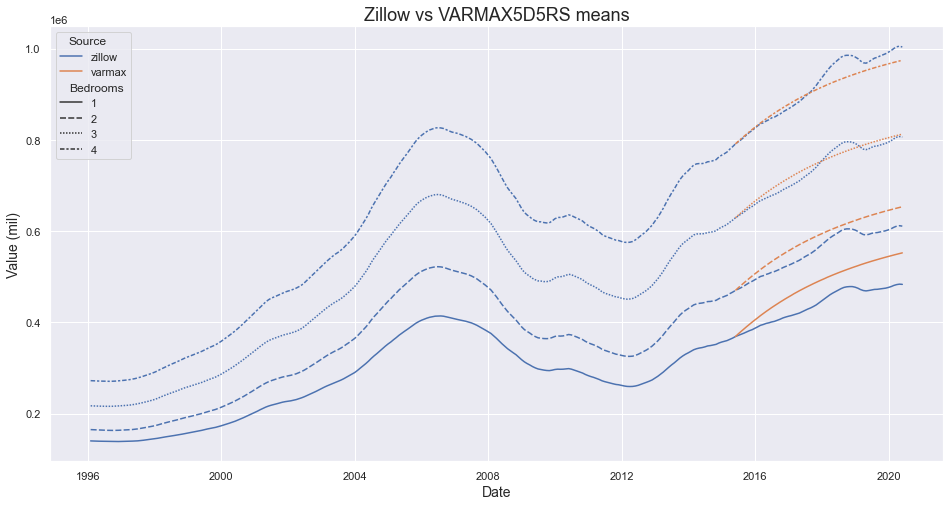

In [45]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX5D5RS means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5RS_means.png')

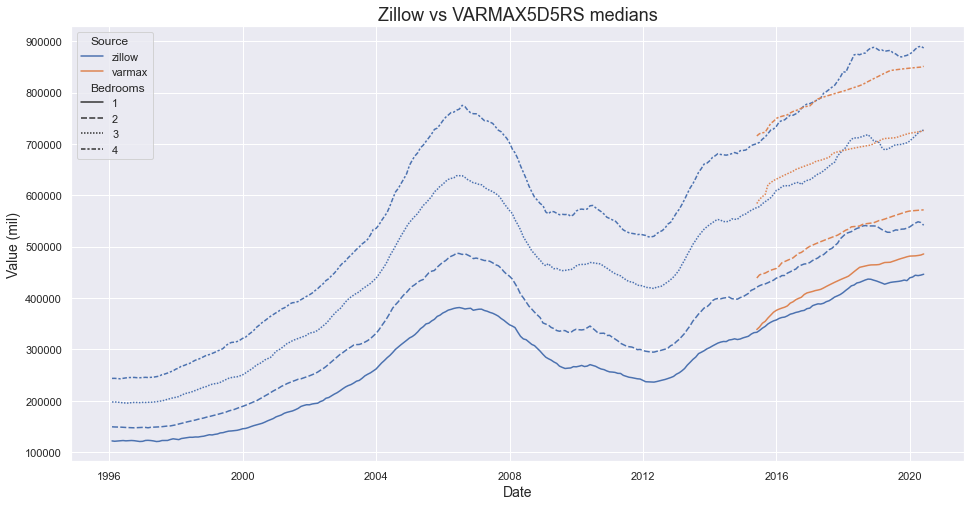

In [46]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX5D5RS medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5RS_medians.png')

In [32]:
pred_dft.head(2)

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90045,284822,722034,847393,1067002
1,2015-05-31,90066,415715,835769,950338,1193218


In [33]:
# let's make a test dataframe
def test_data_form(df, BR_num, val_name):
    temp=pd.DataFrame({})
    for zipcode in pred_dft.Zipcode.unique():
        df_sub = df[(df['Zipcode']==zipcode) & (df['Bedrooms']==BR_num)] #subset by zipcode and num of bedroom
        df_sub = df_sub[df_sub['Date']>='2015-05-31'] # get corresponding date range
        temp['Date'] = pd.date_range('2015-05-31', periods=len(df_sub), freq='M')
        temp[zipcode]=list(df_sub.Value)
    # melt
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # make sure date is datetime
    temp_melt['Date'] = pd.to_datetime(temp_melt.Date)
    # sort
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    return temp_sort

In [34]:
# make a compiled dataframe
test = test_data_form(df,1, 'OneBR')
test2 = test_data_form(df,2, 'TwoBR')
test3 = test_data_form(df,3, 'ThreeBR')
test4 = test_data_form(df,4, 'FourBR')
test['TwoBR'] = test2.TwoBR
test['ThreeBR'] = test3.ThreeBR
test['FourBR'] = test4.FourBR
test.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90045,284822,722034,847393,1067002
61,2015-05-31,90066,415715,835769,950338,1193218
122,2015-05-31,90201,296118,319634,355917,395328
183,2015-05-31,90230,345808,501444,867595,1064471
244,2015-05-31,90240,363270,394755,487184,601498


In [35]:
pred_dft.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)

In [37]:
# calculate the MAEs and add to lists
model_list=[]
MAE_list=[]
for i in range(0,5):
    test_sub = test.iloc[i*481:(1+i)*481*12]
    pred_sub = pred_dft.iloc[i*481:(1+i)*481*12]
    model_list.append('VARMAX5DCRn')
    MAE = mean_absolute_error(test_sub, pred_sub)
    MAE_list.append(MAE)
for i in range(1,5):
    test_sub = test.iloc[:, i]
    pred_sub = pred_dft.iloc[:, i]
    model_list.append('VARMAX5DCRn')
    MAE = mean_absolute_error(test_sub, pred_sub)
    MAE_list.append(MAE)
# make a dataframe and save the info
model_score = pd.DataFrame({
    'Model': model_list,
    'Calc_by': ['15to16', '16to17', '17to18','18to19','19to20', '1BR','2BR','3BR','4BR'],
    'MAE':MAE_list
})
model_score.to_csv('VARMAX5D5RS_score.csv')
model_score

,Model,Calc_by,MAE
0,VARMAX5DCRn,15to16,24892.2985
1,VARMAX5DCRn,16to17,43924.3083
2,VARMAX5DCRn,17to18,53149.0170
3,VARMAX5DCRn,18to19,54662.5416
4,VARMAX5DCRn,19to20,56139.0267
5,VARMAX5DCRn,1BR,67671.6176
6,VARMAX5DCRn,2BR,59599.7621
7,VARMAX5DCRn,3BR,58026.4341
8,VARMAX5DCRn,4BR,64289.2152


since stationary data only have 239 zipcodes, we can't really compare it with other models. Let's view the plots instead.

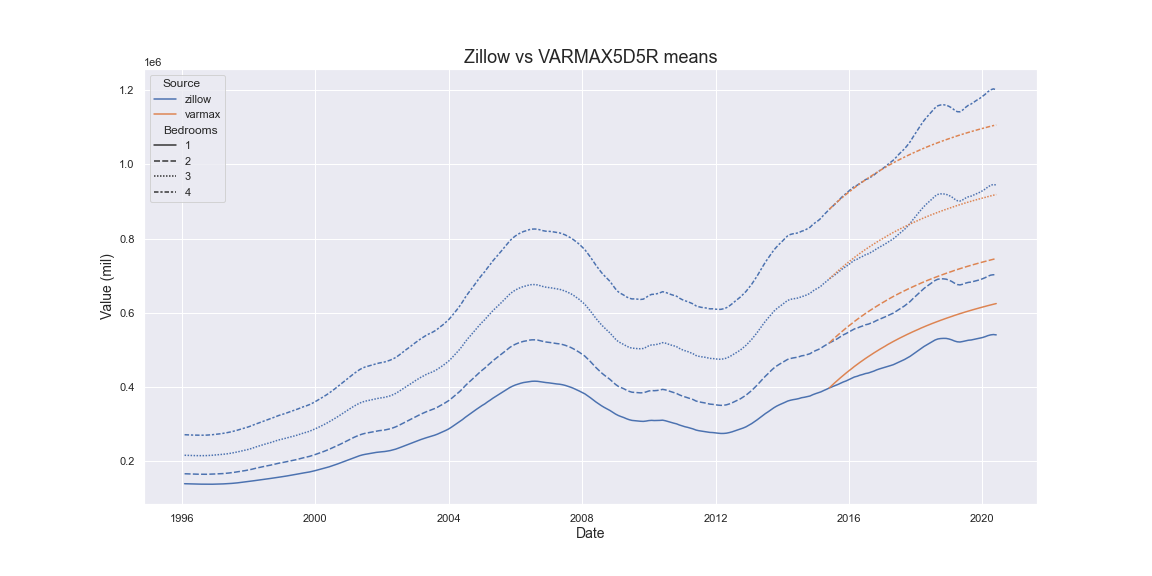

In [48]:
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5R_means.png')

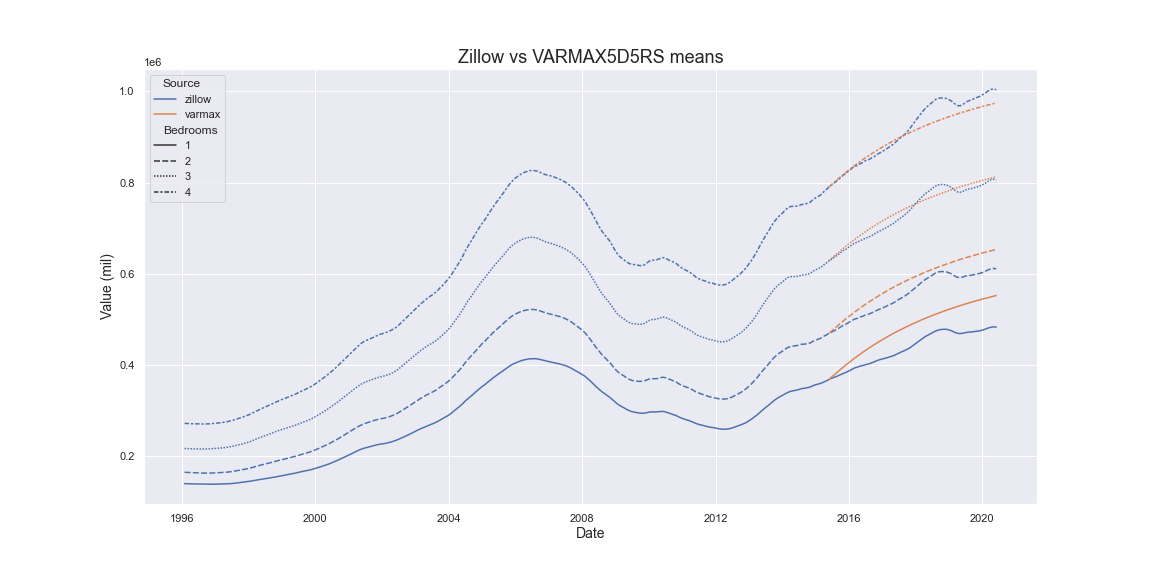

In [49]:
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5RS_means.png')

Both plots are rather similar, with the stationary dataset's result looking slightly better. The predictions for Three bedroom houses seem to be a lot better than the rest.

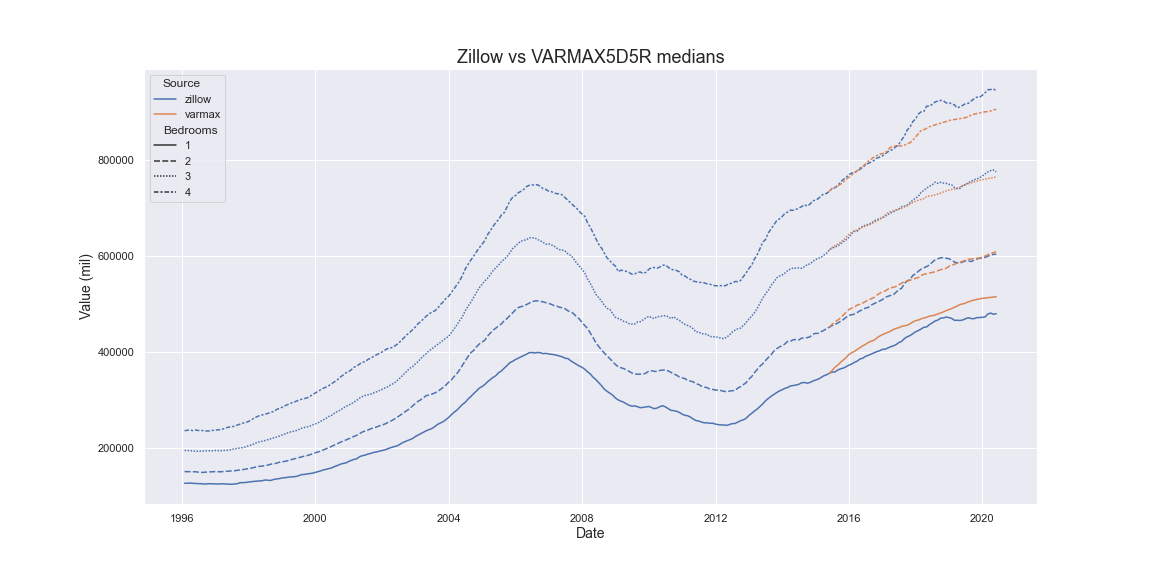

In [47]:
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5R_medians.png')

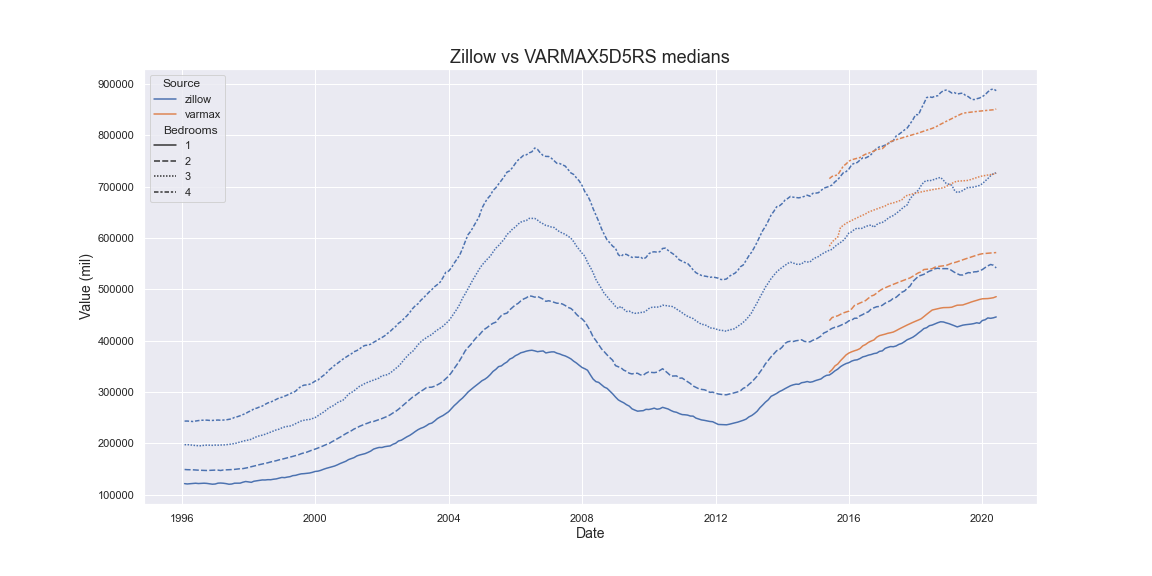

In [50]:
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5RS_medians.png')

5D5R's medians look a lot better than 5D5RS which is the same model but with stationary zipcode data subsets. We will now proceed with traing the whole dataset and get future forecast with VARMAX5D5R, which is the VARMAX model with differenced then 5th rooted data.